In [1047]:
from mpl_toolkits.mplot3d import Axes3D
import scipy
import scipy.integrate
import matplotlib.pyplot as plt
import numpy as np

In [1048]:
# These are our constants
N = 5  # Number of variables
f = 8  # Forcing

In [1049]:
# Adapted from https://en.wikipedia.org/wiki/Lorenz_96_model
def L96(t, X):
    """Lorenz 96 model with constant forcing"""
    # Setting up vector
    Y = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        Y[i] = (X[(i + 1) % N] - X[i - 2]) * X[i - 1] - X[i] + f
    return Y


In [1103]:
# initial condition setup
X0 = f * np.ones(N)
epsilon = np.zeros(N)
# note this is a little farther from equilibrium. want dynamics to not
# evolve from null
epsilon += 1*np.random.randn(N)

X0 += epsilon

In [1122]:
# integrator fidelity & time points setup
t0 = 0.0
t_step = 0.1
T = 3.0
t_np = np.arange(0.0, T, t_step)
t = torch.from_numpy(t_np)

In [1123]:
# run the numerical integrator
RK45_result = scipy.integrate.solve_ivp(L96, (t0, T), X0, 'RK45', dense_output=True)
print()


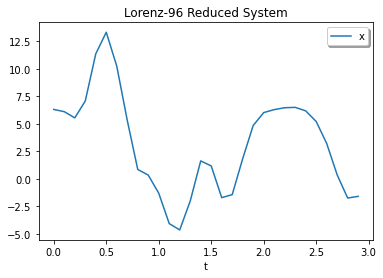

In [1124]:
z = RK45_result.sol(t)[3]
# z = 0.01*np.sum(z, axis=0)
plt.plot(t_np, z.T)
plt.xlabel('t')
plt.legend(['x', 'y'], shadow=True)
plt.title('Lorenz-96 Reduced System')
plt.show()

## New Model: NN map to hidden state that linearizes dynamics

In [1190]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [1203]:
# Neural network to learn mapping to hidden state space
class LinearizationNet(nn.Module):

    # n is the dimension of the observed state y
    def __init__(self, n, d):
        super(LinearizationNet, self).__init__()
        # an affine operation: y = Wx + b
        # self.fc_0 = nn.Linear(n, 500)  
        # self.fc_1 = nn.Linear(500, d)
        self.fc_0 = nn.Linear(n, d)  
        self.fc_1 = nn.Linear(d, d)
        self.fc_2 = nn.Linear(d, d)
        self.fc_3 = nn.Linear(d, d)
        self.fc_4 = nn.Linear(d, d)
        self.fc_5 = nn.Linear(d, d)
        self.fc_6 = nn.Linear(d, d)
        # self.fc_7 = nn.Linear(d, d)
        # self.fc_8 = nn.Linear(d, d)
        # self.fc_9 = nn.Linear(d, d)
        # self.fc_10 = nn.Linear(d, d)
        # self.fc_11 = nn.Linear(d, d)
        # self.fc_12 = nn.Linear(d, d)

    def forward(self, x):

        # feed observed state into hidden state
        x = F.relu(self.fc_0(x))
        # Layer Normalization
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        # pass through residual connections a number of times
        x = x + F.relu(self.fc_1(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        x = x + F.relu(self.fc_2(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        x = x + F.relu(self.fc_3(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        x = x + F.relu(self.fc_4(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        x = x + F.relu(self.fc_5(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        # x = x + F.relu(self.fc_6(x))
        # x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        # x = x + F.relu(self.fc_7(x))
        # x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        # x = x + F.relu(self.fc_8(x))
        # x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        # x = x + F.relu(self.fc_9(x))
        # x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        # x = x + F.relu(self.fc_10(x))
        # x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        # x = x + F.relu(self.fc_11(x))
        # x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        x = x + self.fc_6(x)

        # x = F.relu(self.fc_0(x))
        # x = self.fc_1(x)

        return x

# Neural network to learn inverse of LinearizationNet
class ReconstructionNet(nn.Module):

    # n is the dimension of the observed state y
    def __init__(self, n, d):
        super(ReconstructionNet, self).__init__()
        # an affine operation: y = Wx + b
        # FC
        # self.fc_3 = nn.Linear(500, n)
        # self.fc_2 = nn.Linear(d, 500)
        # ResNet
        # self.fc_12 = nn.Linear(d, n)
        # self.fc_11 = nn.Linear(d, d)
        # self.fc_10 = nn.Linear(d, d)
        # self.fc_9 = nn.Linear(d, d)
        # self.fc_8 = nn.Linear(d, d)
        # self.fc_7 = nn.Linear(d, d)
        self.fc_6 = nn.Linear(d, n)
        self.fc_5 = nn.Linear(d, d)
        self.fc_4 = nn.Linear(d, d)
        self.fc_3 = nn.Linear(d, d)
        self.fc_2 = nn.Linear(d, d)
        self.fc_1 = nn.Linear(d, d)
        self.fc_0 = nn.Linear(d, d)

    def forward(self, x):

        # pass through residual connections a number of times
        x = x + F.relu(self.fc_0(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        x = x + F.relu(self.fc_1(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        x = x + F.relu(self.fc_2(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        x = x + F.relu(self.fc_3(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        x = x + F.relu(self.fc_4(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        x = x + F.relu(self.fc_5(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        # x = x + F.relu(self.fc_6(x))
        # x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        # x = x + F.relu(self.fc_7(x))
        # x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        # x = x + F.relu(self.fc_8(x))
        # x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        # x = x + F.relu(self.fc_9(x))
        # x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        # x = x + F.relu(self.fc_10(x))
        # x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        # x = x + F.relu(self.fc_11(x))
        # x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        # feed observed state into hidden state
        x = self.fc_6(x)

        # x = F.relu(self.fc_2(x))
        # x = self.fc_3(x)

        return x

# Model for the (affine) linear dynamics of model
# note that this is essentially linear dynamics, 
# but we forcefully add the observable phi(x) = 1
class DynamicsNet(nn.Module):

    def __init__(self, T, t_del, d):
        super(DynamicsNet, self).__init__()
        # global vars init
        # number of time steps to integrate forward
        self.T = T
        # time of each time integration (delta t)
        self.t_del = t_del
        # dimension of hidden space
        self.d = d
        # a linear operation: y = Mx
        M = torch.Tensor(d, d)
        b = torch.Tensor(d)
        self.M = nn.Parameter(M)  # nn.Parameter is a Tensor that's a module parameter.
        self.b = nn.Parameter(b)  # nn.Parameter is a Tensor that's a module parameter.

        torch.nn.init.normal_(self.M) # weight init
        torch.nn.init.normal_(self.b) # weight init
        # normalize (avoid exponential explosion)
        # self.M.data = (1 / self.M.max()) * self.M.data
        (U, S, Vh) = torch.svd(M)
        # normalize s.t. largest singular value is 1
        self.M.data = (1/S[0])*self.M.data

    def forward(self, x):

        # matrix fc_0 learns derivative of current point,
        # then we integrate to next timestep here

        output = torch.zeros((self.T, self.d))
        output[0,:] = x
        for i in range(self.T-1):
            prv = output[i,:].clone()
            nxt = prv + self.t_del*(self.M @ prv + self.b)
            output[i+1,:] = nxt
            # # project back to LinearizationNet function space
            # output[i+1,:] = (nxt - nxt.mean()) / nxt.std()
        return output

# Neural network to learn kernel's self-attention

# modeled after self-attention. Note there is a separate
# hidden feature space for the kernel, not necessarily
# the feature space associate with the observables

# T is number of time steps to forecast
class KernelNet(nn.Module):

    def __init__(self, n, d):
        super(KernelNet, self).__init__()
        # global vars init
        # dimension of observed space
        self.n = n
        # dimension of hidden space
        self.d = d
        # for description of self-attention model used, see:
        # https://arxiv.org/pdf/2010.03957.pdf


        # FC for kernel embedding
        self.fc_0_embed = nn.Linear(n, 500)
        self.fc_1_embed = nn.Linear(500, d)

    def forward(self, x):

        # input is of shape (l \times n), where l is context length
        # context is stored in x[:-1,:], current state is x[-1,:]
        # apply all networks to data x

        x = F.relu(self.fc_0_embed(x))
        x = self.fc_1_embed(x)

# nn.Module class to represent the learnable time embedding
# takes as argument ((y, t, t, ..., t)), where there are
# (size_embedding) t's
class TimeEmbedding(nn.Module):
    def __init__(self, size_embedding):
        super(TimeEmbedding, self).__init__()
        # an affine operation: y = Wx + b
        weights = torch.Tensor(size_embedding - 2)
        self.weights = nn.Parameter(weights)  # nn.Parameter is a Tensor that's a module parameter.

        nn.init.xavier_normal_(self.weights) # weight init

        # same thing for bias
        bias = torch.Tensor(size_embedding - 2)
        self.bias = nn.Parameter(bias)  # nn.Parameter is a Tensor that's a module parameter.

        nn.init.xavier_normal_(self.bias) # weight init

    def forward(self, x):

        # first transform time inputs (except for linear component)
        x[2:] = x[2:] * self.weights + self.bias
        # then apply periodic nonlinearity
        x[2:] = torch.sin(x[2:])
        return x

In [1207]:
# Global Variables

# total number of time steps
T_steps = len(t)
# hidden space dimension
d = 90
# learning rate for models
lr = 0.07
# heuristic for constructing time_scale
k = torch.arange(T_steps-1).float()

In [1208]:
z = RK45_result.sol(t).T
data = torch.from_numpy(z).float()

lin_net = LinearizationNet(N, d)
dy_net = DynamicsNet(T_steps, t_step, d)
rec_net = ReconstructionNet(N, d)

opt_lin = optim.Adam(lin_net.parameters(), lr=lr)
opt_dy = optim.Adam(dy_net.parameters(), lr=0.1*lr)
opt_rec = optim.Adam(rec_net.parameters(), lr=lr)

# print(lin_net.fc_0.weight)

# Coupled Training

In [1209]:
# lambda for reconstruction loss
lmbda = 1
# alphas for time normalization
alphas = [0.5, 0.1, 0.005]
# alphas = [0.0, 0.0, 0.0]
# Linearization Training Loop
for a in range(len(alphas)):
    # set the current time scale. note this is a vector of lenth (T_steps)
    time_scale = torch.exp(-alphas[a]*k).reshape((T_steps-1,1))

    # LR reset
    for g in opt_lin.param_groups:
        g['lr'] = 0.1*lr
    for g in opt_rec.param_groups:
        g['lr'] = 0.1*lr
    for g in opt_dy.param_groups:
        g['lr'] = 0.01*lr

    for i in range(3000):
        # zero the parameter gradients
        lin_net.zero_grad()
        dy_net.zero_grad()
        rec_net.zero_grad()

        # forward
        outputs = lin_net(data)
        # apply linear transformations
        outputs_generated = dy_net(outputs[0,:])
        # loss = 0
        # for j in range(0,T_steps-1):
        #     outputs_generated[j+1,:] = dy_net(outputs_generated[j,:])

        # linearization loss
        loss = 0.5*(((outputs[1:,:] - outputs_generated[1:,:])).pow(2)*time_scale).sum()
        # reconstruction loss
        reconstructed = rec_net(outputs)
        loss += 0.5*lmbda*(reconstructed - data).pow(2).sum()

        if loss < 1e-6:
            print(f'this is loss {loss}')
            break

        if i % 300 == 0:
            print(f'loss {loss} step {i} alpha {alphas[a]}')
        # backward
        loss.backward()

        # optimize
        opt_lin.step()
        opt_dy.step()
        opt_rec.step()

        # LR drop
        # Set new lr
        if i == 1500:
            # lr = 0.6*lr
            for g in opt_lin.param_groups:
                g['lr'] = 0.05*lr
            for g in opt_rec.param_groups:
                g['lr'] = 0.05*lr
            for g in opt_dy.param_groups:
                g['lr'] = 0.005*lr

        # LR drop
        # Set new lr
        if i == 3000:
            # lr = 0.6*lr
            for g in opt_lin.param_groups:
                g['lr'] = 0.01*lr
            for g in opt_rec.param_groups:
                g['lr'] = 0.01*lr
            for g in opt_dy.param_groups:
                g['lr'] = 0.001*lr

print(f'final loss: {loss}')
print('done!')

loss 2046.31884765625 step 0 alpha 0.5
loss 17.117891311645508 step 300 alpha 0.5
loss 6.908626079559326 step 600 alpha 0.5
loss 0.8030908703804016 step 900 alpha 0.5
loss 1.1820611953735352 step 1200 alpha 0.5
loss 0.34206464886665344 step 1500 alpha 0.5
loss 0.1977146565914154 step 1800 alpha 0.5
loss 0.2599356472492218 step 2100 alpha 0.5
loss 0.1492873877286911 step 2400 alpha 0.5
loss 8.482828140258789 step 2700 alpha 0.5
loss 173.5631561279297 step 0 alpha 0.1
loss 2.301985502243042 step 300 alpha 0.1
loss 1314.815673828125 step 600 alpha 0.1
loss 3.6172027587890625 step 900 alpha 0.1
loss 24.420963287353516 step 1200 alpha 0.1
loss 0.7878528237342834 step 1500 alpha 0.1
loss 0.5117956399917603 step 1800 alpha 0.1
loss 0.3492392599582672 step 2100 alpha 0.1
loss 0.25006455183029175 step 2400 alpha 0.1
loss 0.18871541321277618 step 2700 alpha 0.1
loss 0.7599276304244995 step 0 alpha 0.005
loss 2.128842830657959 step 300 alpha 0.005
loss 0.701053261756897 step 600 alpha 0.005
loss 

In [963]:
for g in opt_lin.param_groups:
    g['lr'] = 0.01
for g in opt_rec.param_groups:
    g['lr'] = 0.01
for g in opt_dy.param_groups:
    g['lr'] = 0.001


# Test

In [1210]:
outputs = lin_net(data)
# apply linear transformations
outputs_generated = dy_net(outputs[0,:])
# loss = 0
# for j in range(0,T_steps-1):
#     outputs_generated[j+1,:] = dy_net(outputs_generated[j,:])

# linearization loss
print(0.5*((outputs[1:,:] - outputs_generated[1:,:])).pow(2).sum())
print(time_scale)

tensor(0.2804, grad_fn=<MulBackward0>)
tensor([[1.0000],
        [0.9950],
        [0.9900],
        [0.9851],
        [0.9802],
        [0.9753],
        [0.9704],
        [0.9656],
        [0.9608],
        [0.9560],
        [0.9512],
        [0.9465],
        [0.9418],
        [0.9371],
        [0.9324],
        [0.9277],
        [0.9231],
        [0.9185],
        [0.9139],
        [0.9094],
        [0.9048],
        [0.9003],
        [0.8958],
        [0.8914],
        [0.8869],
        [0.8825],
        [0.8781],
        [0.8737],
        [0.8694]])


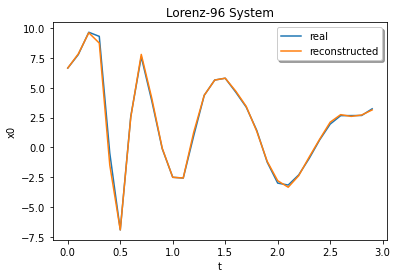

In [1222]:
with torch.no_grad():
    # collection of all hidden states
    hidden_data = lin_net(data)
    hidden_data_generated = dy_net(hidden_data[0,:])

T_test = T
t_test = np.arange(0.0, T_test, t_step)

test_index = 0

z = RK45_result.sol(t_test)[test_index]

test_hidden = hidden_data_generated.detach().clone()
# print(test_hidden.numel())
for i in range((int)((T_test - T)/t_step)):
    prev = test_hidden[-1,:]
    nxt = (prev + dy_net.M.data @ prev).reshape((1,prev.numel()))
    test_hidden = torch.cat([test_hidden,nxt], dim=0)

test_rec = rec_net(test_hidden)
# z = 0.01*np.sum(z, axis=0)
plt.plot(t_test, z.T)

test_plot = test_rec[:,test_index].detach().numpy().T
plt.plot(t_test[:], test_plot[:])
plt.xlabel('t')
plt.ylabel(f'x{test_index}')
plt.legend(['real', 'reconstructed'], shadow=True)
plt.title('Lorenz-96 System')
plt.show()

In [1185]:
print(dy_net.b)

Parameter containing:
tensor([ 0.3107, -1.5707, -1.0184, -0.9338,  0.2843,  0.1653, -0.2064,  0.9701,
        -0.3413,  0.6369], requires_grad=True)


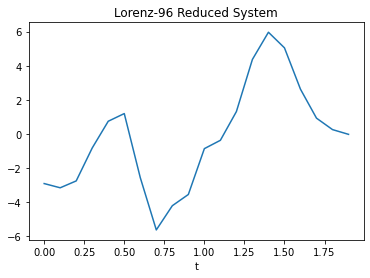

In [1021]:
with torch.no_grad():
    # collection of all hidden states
    hidden_data = lin_net(data)
    hidden_data_generated = dy_net(hidden_data[0,:])

plt.plot(t_test[:], hidden_data[:,0].detach().numpy().T)
plt.xlabel('t')
plt.title('Lorenz-96 Reduced System')
plt.show()

